In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# rsfMRI dataset
N = 715
num_train = 0
for subject in range(N):
    filename = '/Users/wuzhejun/Downloads/corr/projection_ica_window8_subject%d.npy' % subject
    tc = np.load(filename) 
    num_train += tc.shape[1]

corr_dimension = 23
corr_dimension_upper = 276
x_train = np.zeros(shape=(num_train,corr_dimension_upper))

idx = 0
for subject in range(N):
    filename = '/Users/wuzhejun/Downloads/corr/projection_ica_window8_subject%d.npy' % subject
    tc = np.load(filename) 
    
    for t in range(tc.shape[1]):
        corr = np.reshape(tc[:,t],[corr_dimension,corr_dimension])
        upper = corr[np.triu_indices(corr_dimension)]
        x_train[idx,:] = np.squeeze(upper)
        idx += 1
        
x_train = x_train.astype('float32')
mean_value = np.mean(x_train)
max_value = np.max(x_train)
min_value = np.min(x_train)

In [3]:
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 200
intermediate_dim_2 = 50
batch_size = 256
latent_dim = 3
cat_dim = 1
epochs = 20

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
y = Dense(intermediate_dim, activation='tanh', name='encoder_intermediate')(inputs)
x = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(y)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='tanh')(latent_inputs)
outputs = Dense(original_dim, activation='tanh')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 276)          0                                            
__________________________________________________________________________________________________
encoder_intermediate (Dense)    (None, 200)          55400       encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_intermediate_2 (Dense)  (None, 50)           10050       encoder_intermediate[0][0]       
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 3)            153         encoder_intermediate_2[0][0]     
__________________________________________________________________________________________________
z_log_var 

In [4]:
models = (encoder, decoder)

# reconstruction loss
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim * 10

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss+kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size)
vae.save_weights('vae_mlp_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 276)               0         
_________________________________________________________________
encoder (Model)              [(None, 3), (None, 3), (N 65756     
_________________________________________________________________
decoder (Model)              (None, 276)               56276     
Total params: 122,032
Trainable params: 122,032
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
186854/186854 [==============================] - 5s 29us/step - loss: 84.4434
Epoch 2/20
186854/186854 [==============================] - 6s 32us/step - loss: 81.8655
Epoch 3/20
186854/186854 [==============================] - 5s 26us/step - loss: 81.7605
Epoch 4/20
186854/186854 [==============================] - 6s 30us/step - loss: 81.6910
Epoch 5/20
186854/186854 [==================

<IPython.core.display.Javascript object>


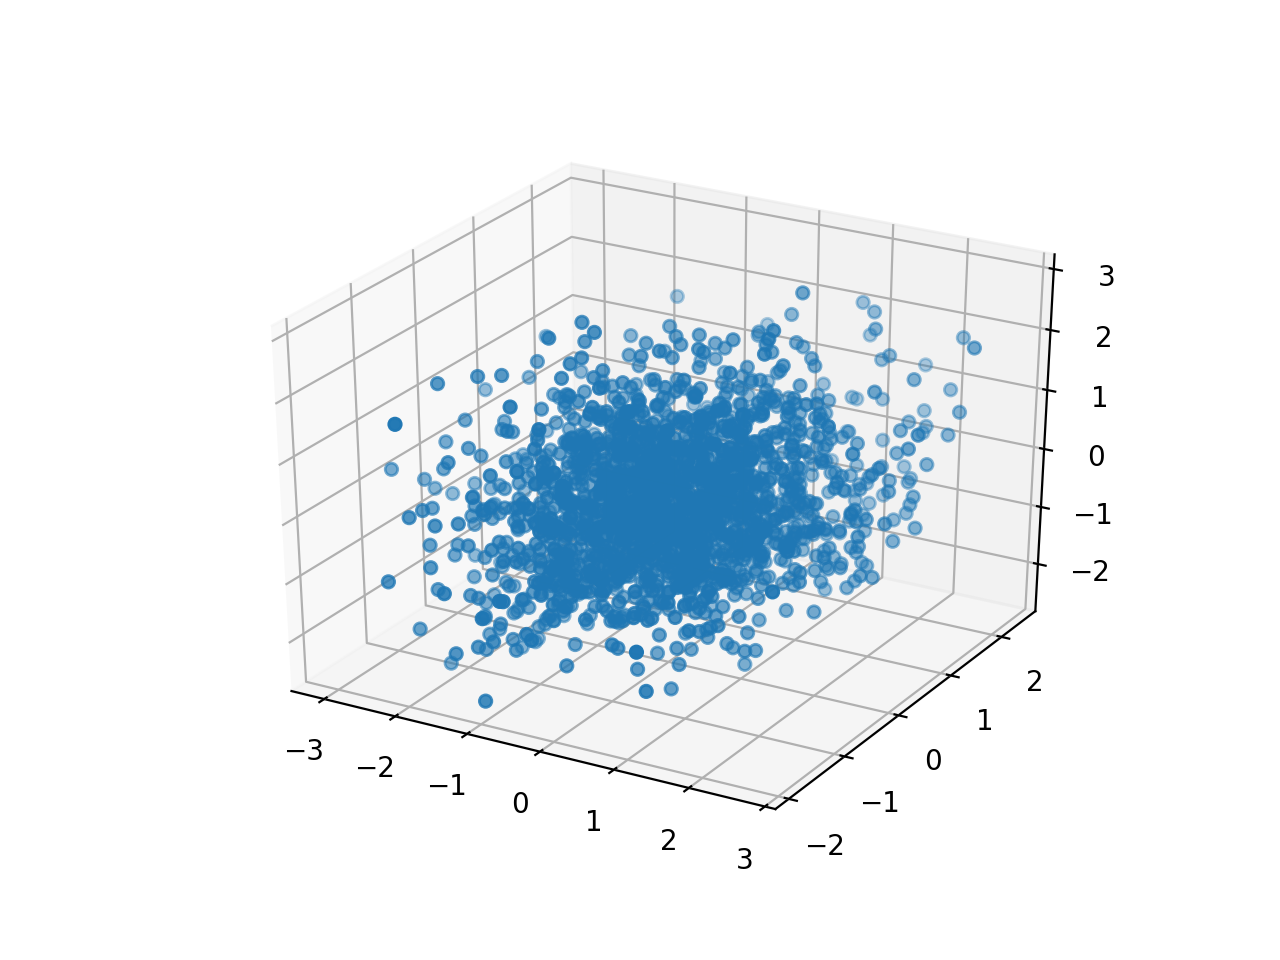

(-3.3340346693992613,
 3.004925715923309,
 -3.3459195137023925,
 3.796169662475586)

In [5]:
from mpl_toolkits.mplot3d import Axes3D
[z_mean, z_log_var, z] = encoder.predict(x_train[np.random.randint(num_train, size=2000),:],batch_size=batch_size)
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_mean[:, 0], z_mean[:, 1],z_mean[:,2])
ax.axis('equal')